# Time Series Analysis with Twitter and CDC data

In [32]:
import warnings
warnings.filterwarnings('ignore')

# Load required libraries
import pandas as pd
from pandas import Series
import matplotlib.pyplot as plt
%matplotlib inline
from datetime import datetime
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
import numpy as np
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6
import statsmodels.api as sm  
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import itertools
#http://people.duke.edu/~rnau/whatuse.htm
#http://www.seanabu.com/2016/03/22/time-series-seasonal-ARIMA-model-in-python/
#https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4937903/

## Cleaning Data

### CDC Data Cleaning

In [6]:
#http://www.cs.uml.edu/~bliu/pub/CPNS_2011.pdf
cdc_df = pd.read_csv('FluViewPhase2Data/ILINet.csv')
cdc_df.reset_index(inplace=True) # Resets the index, makes factor a column
cdc_df.drop('PERCENTAGE OF VISITS FOR INFLUENZA-LIKE-ILLNESS REPORTED BY SENTINEL PROVIDERS',axis=1,inplace=True) # drop factor from axis 1 and make changes permanent by inplace=True
cdc_df.columns = cdc_df.iloc[0]
cdc_df = cdc_df.iloc[1:]
print(cdc_df.columns)
cdc_df = cdc_df.drop(['REGION TYPE', 'REGION', 'AGE 0-4', 'AGE 25-49', 'AGE 25-64', 'AGE 5-24',
       'AGE 50-64', 'AGE 65', 'NUM. OF PROVIDERS'], axis=1)

Index(['REGION TYPE', 'REGION', 'YEAR', 'WEEK', '% WEIGHTED ILI',
       '%UNWEIGHTED ILI', 'AGE 0-4', 'AGE 25-49', 'AGE 25-64', 'AGE 5-24',
       'AGE 50-64', 'AGE 65', 'ILITOTAL', 'NUM. OF PROVIDERS'],
      dtype='object', name=0)


In [7]:
cdc_df["Date"] = pd.to_datetime(cdc_df.WEEK.astype(str)+
                          cdc_df.YEAR.astype(str).add('-1') ,format='%W%Y-%w')
cdc_df.set_index(cdc_df['Date'], inplace=True)
cdc_df.drop(['Date', 'YEAR', 'WEEK', '% WEIGHTED ILI', '%UNWEIGHTED ILI'], axis=1, inplace=True)
cdc_df['ILITOTAL'] = cdc_df['ILITOTAL'].astype('int64')

In [49]:
cdc_df

,ILITOTAL
Date,
2017-10-02,12873
2017-10-09,13298
2017-10-16,14364
2017-10-23,15860
2017-10-30,17095
2017-11-06,19086
2017-11-13,21932
2017-11-20,19863
2017-11-27,23796


### Google Search Trends

In [9]:
google_df = pd.read_csv('google_trends/multiTimeline.csv')
google_df.reset_index(inplace=True) # Resets the index, makes factor a column
google_df.columns = google_df.iloc[0]
google_df = google_df.iloc[1:]
google_df.head()

,Week,flu: (United States)
1,2017-10-02,18
2,2017-10-09,18
3,2017-10-16,18
4,2017-10-22,18
5,2017-10-30,16


In [10]:
google_df.rename(columns={'Week': 'Date'}, inplace=True)
google_df.rename(columns={'flu: (United States)': 'Count'}, inplace=True)
google_df.set_index(google_df['Date'], inplace=True)
google_df.drop(['Date'], axis=1, inplace=True)
google_df['Count'] = google_df['Count'].astype('int64')

### Twitter Cleaning

In [11]:
#will need to delete retweets, tweets from the same user within a week (not a new case)
#normalize scale of CDC visits and tweets 

## Visualizations

In [12]:
#include framework model here -- tracking influenza-like illness 

### CDC ILI Visits 2017-2018

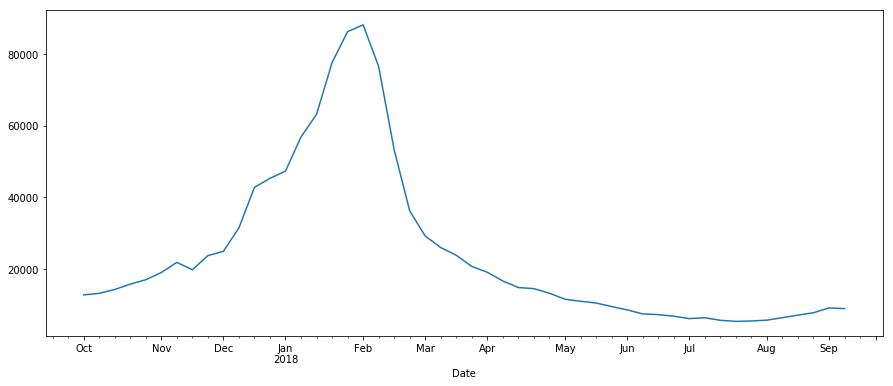

In [13]:
#show distribution (count of flu-related tweets) over time 
#https://github.com/learn-co-students/ds-ts-visualize_ts-nyc-career-ds-062518/tree/solution
#need Pandas Series with date and tweet count per date 
#overlay with CDC data to see how it corresponds -- have dropdown menu 
cdc_df.plot()
plt.legend().set_visible(False)
plt.show()

In [14]:
#maybe heat map by month and week
# plt.matshow(cdc_df, interpolation=None, aspect='auto', cmap=plt.cm.Spectral_r)
# plt.show()

### Google Trends Data 2017-2018 ('Flu')

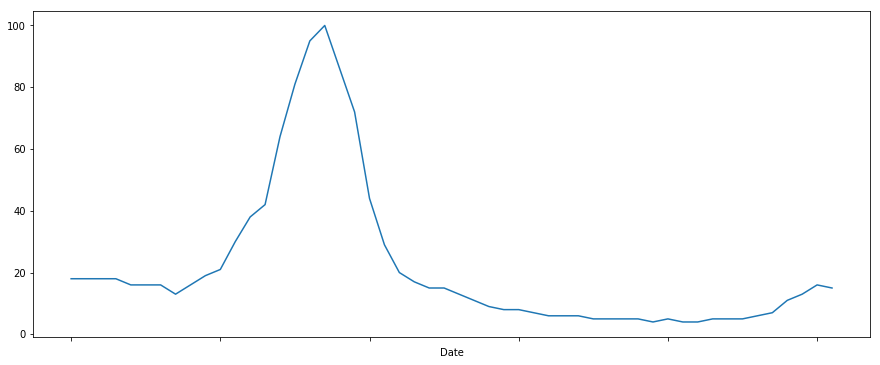

In [15]:
google_df.plot()
plt.legend().set_visible(False)
plt.show()

### Flu-Related Tweets 2017-2018 

In [ ]:
twitter_df.plot()
plt.legend().set_visible(False)
plt.show()

## Assessing Stationarity

In [16]:
#Plot rolling statistics
def check_stationarity(df,window,count):
    moving_avg = df.rolling(window).mean() #4 week lag
    moving_std = df.rolling(window).std()

    orig = plt.plot(df, color='blue',label='Original')
    mean = plt.plot(moving_avg, color='red', label='Rolling Mean')
    std = plt.plot(moving_std, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(count, autolag='AIC')

    # Extract and display test results in a user friendly manner
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)
#mean and standard deviation increasing with time = not stationary

### Dickey-Fuller Test

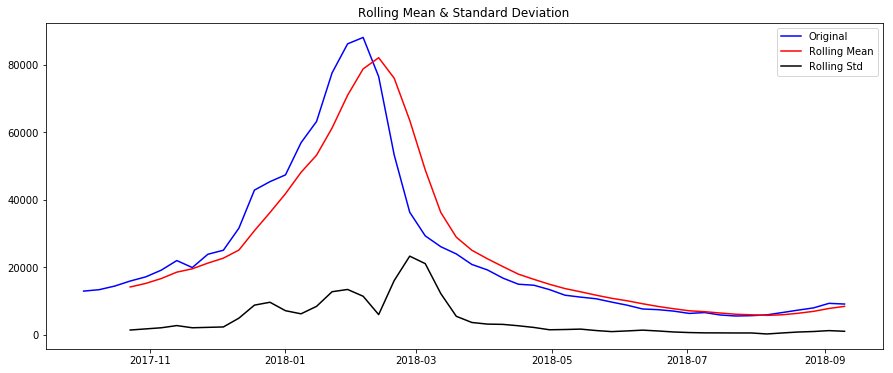

Results of Dickey-Fuller Test:
Test Statistic                 -1.702719
p-value                         0.429712
#Lags Used                      2.000000
Number of Observations Used    47.000000
Critical Value (1%)            -3.577848
Critical Value (5%)            -2.925338
Critical Value (10%)           -2.600774
dtype: float64


In [17]:
# Perform the dickey Fuller test 
cdc_df.dropna(inplace=True)
check_stationarity(cdc_df, 4, cdc_df['ILITOTAL'])
#null: time-series is non-stationary 
#p-value: 0.429
#p-value > 0.05, fail to reject null --> time-series is non-stationary

### Decomposition Visualization

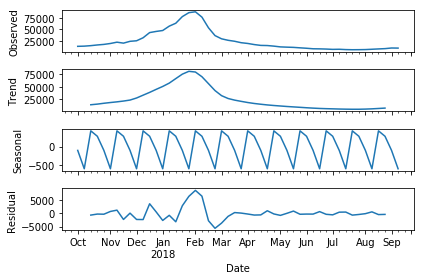

In [100]:
result = seasonal_decompose(cdc_df, freq=4) #every 4 weeks
result.plot()
plt.show()

## Stationarization of Data

In [ ]:
#linear regression assumption that observations are independent of each other: data needs to be stationary

### Log Transformation

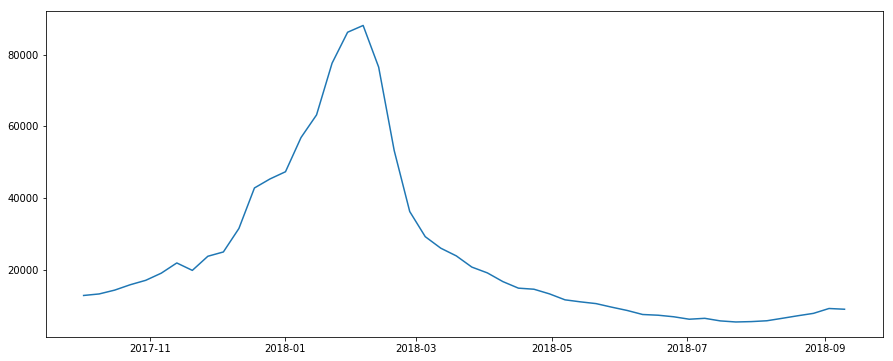

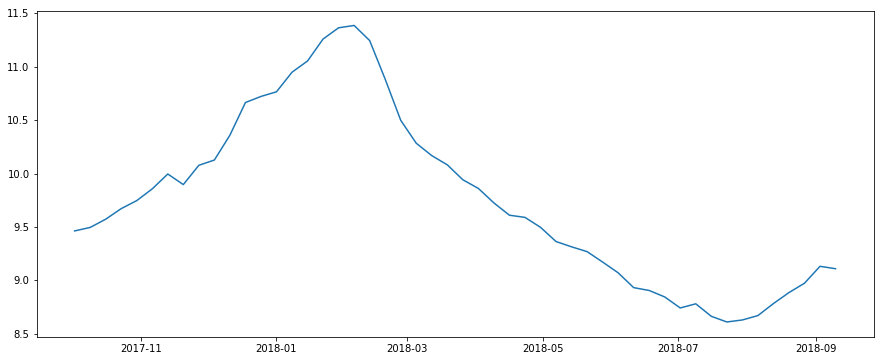

In [128]:
# Log transform timeseries and compare with original to check the effect
cdc_log = np.log(cdc_df)

rcParams['figure.figsize'] = 15, 6
plt.plot(cdc_df)
plt.show()
plt.plot(cdc_log)
#no change

### First Differencing

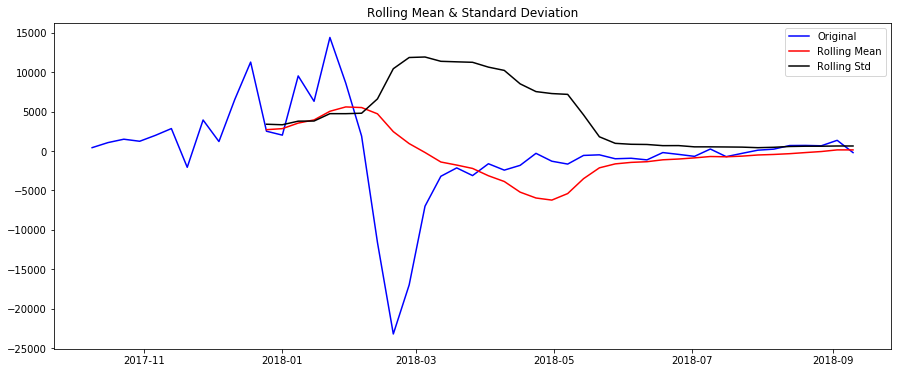

Results of Dickey-Fuller Test:
Test Statistic                 -3.382108
p-value                         0.011584
#Lags Used                      1.000000
Number of Observations Used    47.000000
Critical Value (1%)            -3.577848
Critical Value (5%)            -2.925338
Critical Value (10%)           -2.600774
dtype: float64


In [20]:
cdc_diff = cdc_df - cdc_df.shift()
cdc_diff.dropna(inplace=True)
check_stationarity(cdc_diff, 12, cdc_diff['ILITOTAL'])
#p-value 0.011584

### First Differencing with Log

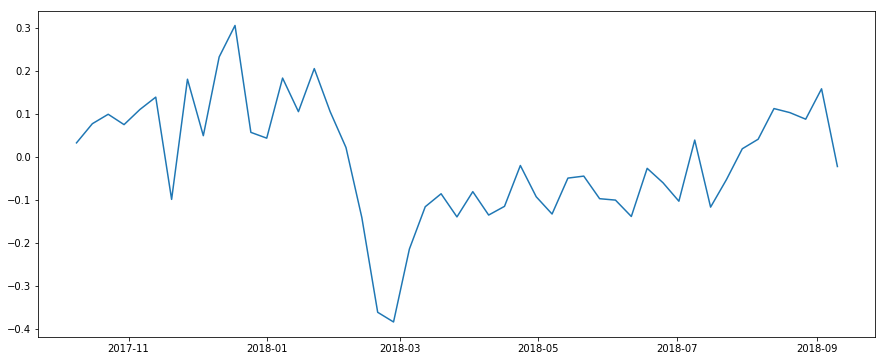

In [117]:
#take the difference of the observation at a particular instant with that at the previous instant
# Calculate the difference of log transformed ts with shifted log transformed ts and plot.
cdc_log = np.log(cdc_df)
cdc_log_diff = cdc_log - cdc_log.shift()
rcParams['figure.figsize'] = 15, 6
plt.plot(cdc_log_diff)

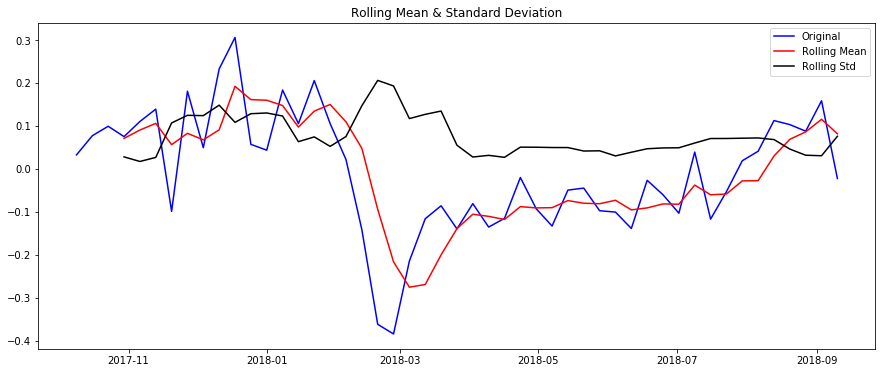

Results of Dickey-Fuller Test:
Test Statistic                 -1.702719
p-value                         0.429712
#Lags Used                      2.000000
Number of Observations Used    47.000000
Critical Value (1%)            -3.577848
Critical Value (5%)            -2.925338
Critical Value (10%)           -2.600774
dtype: float64


In [129]:
cdc_log_diff.dropna(inplace=True)
check_stationarity(cdc_log_diff, 12, cdc_log_diff['ILITOTAL'])
#p-value 0.044476

### Seasonal Differencing

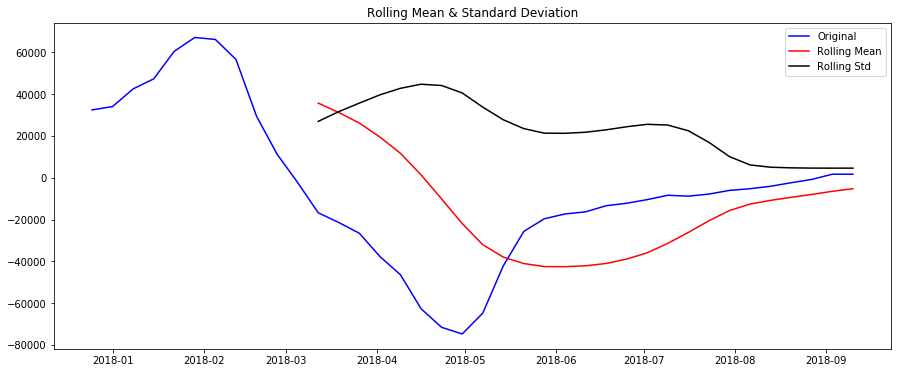

Results of Dickey-Fuller Test:
Test Statistic                 -3.870388
p-value                         0.002264
#Lags Used                      5.000000
Number of Observations Used    32.000000
Critical Value (1%)            -3.653520
Critical Value (5%)            -2.957219
Critical Value (10%)           -2.617588
dtype: float64


In [18]:
cdc_seasonal_diff= cdc_df - cdc_df.shift(12)
cdc_seasonal_diff.dropna(inplace=True)
check_stationarity(cdc_seasonal_diff, 12, cdc_seasonal_diff['ILITOTAL'])
#p-value: 0.002264 -- stationary data 

### First Differencing of Seasonal Difference

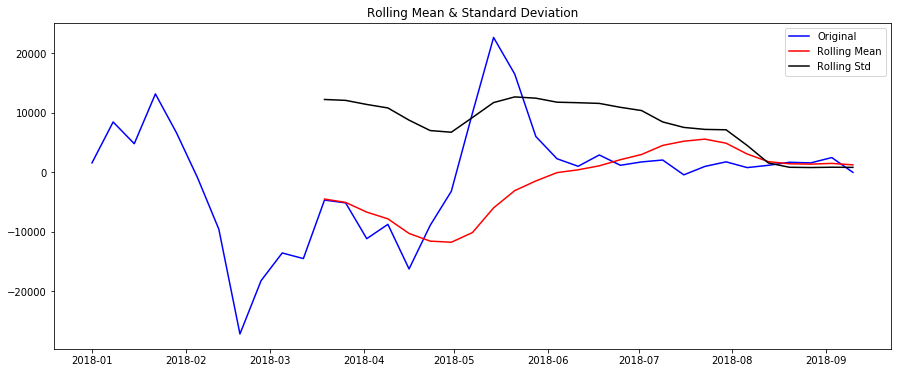

Results of Dickey-Fuller Test:
Test Statistic                 -2.729260
p-value                         0.069110
#Lags Used                     10.000000
Number of Observations Used    26.000000
Critical Value (1%)            -3.711212
Critical Value (5%)            -2.981247
Critical Value (10%)           -2.630095
dtype: float64


In [21]:
cdc_seasonal_first_diff = cdc_diff - cdc_diff.shift(12)
cdc_seasonal_first_diff.dropna(inplace=True)
check_stationarity(cdc_seasonal_first_diff, 12, cdc_seasonal_first_diff['ILITOTAL'])
#p-value: 0.069110

### Results:
* Take seasonal difference to remove the seasonality of the data

## Auto-Correlation & Partial Auto-Correlation: Visualizations

ACF & PACF used to determine how past and future data points are related in a time series for ARIMA modeling

Source: https://stats.stackexchange.com/questions/77248/what-is-autocorrelation-function

### ACF Chart for Seasonal Differences

Auto-Correlation Function (ACF): Used to find patterns in data. Correlation between points separated by various time lags. Tells you how correlated points are with each other, based on how many time steps they are separated by. That is the gist of autocorrelation, it is how correlated past data points are to future data points, for different values of the time separation. Typically, you'd expect the autocorrelation function to fall towards 0 as points become more separated (i.e. n becomes large in the above notation) because its generally harder to forecast further into the future from a given set of data. This is not a rule, but is typical.

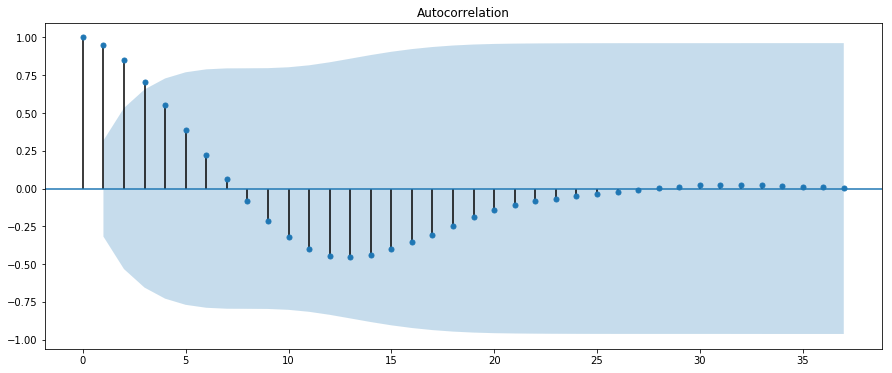

In [22]:
rcParams['figure.figsize'] = 15, 6
plot_acf(cdc_seasonal_diff)
# plot_acf(cdc_df)
plt.show()

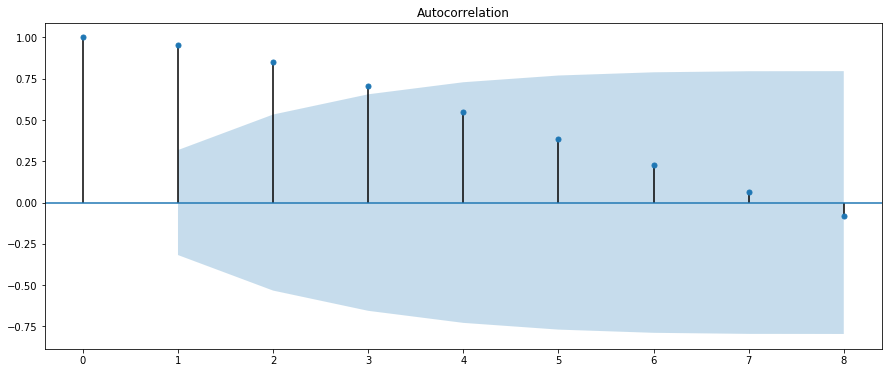

In [23]:
rcParams['figure.figsize'] = 15, 6
plot_acf(cdc_seasonal_diff, lags=8)
# plot_acf(cdc_df)
plt.show()

#Auto-correlation negative at lag 8

### PACF Chart for Seasonal Differences

Partial auto-correlation function shows correlation between two points that are separated by some number of periods n, BUT with the effect of the intervening correlations removed. This is important because lets say that in reality, each data point is only directly correlated with the NEXT data point, and none other. However, it will APPEAR as if the current point is correlated with points further into the future, but only due to a "chain reaction" type effect, i.e., T1 is directly correlated with T2 which is directly correlated with T3, so it LOOKs like T1 is directly correlated with T3. The PACF will remove the intervening correlation with T2 so you can better discern patterns. 

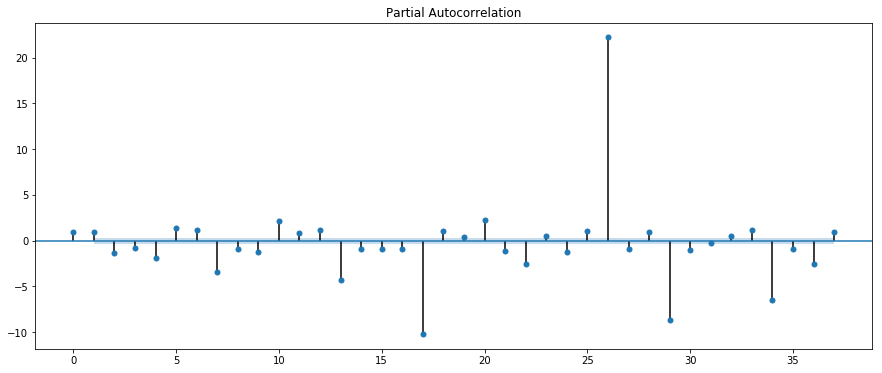

In [24]:
# Plot acf by passing lags=100 as an argument to plot_pacf()
rcParams['figure.figsize'] = 15, 6
plot_pacf(cdc_seasonal_diff)
plt.show()

## Seasonal ARIMA Modeling to Forecast Influenza-Like Cases

In [ ]:
#predict ILI incidence as a linear function of current and 
#old Social Network data and historical ILI data (CDC data) -- assess model goodness of fit with AIC, lowest value 
#https://github.com/learn-co-students/ds-ts-ARIMA-nyc-career-ds-062518/tree/solution

### Model with CDC data only

In [30]:
def arima_grid_search():
    # Define the p, d and q parameters to take any value between 0 and 2
    p = d = q = range(0, 2)
    # Generate all different combinations of p, q and q triplets
    pdq = list(itertools.product(p, d, q))
    # Generate all different combinations of seasonal p, q and q triplets
    pdqs = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
    ans = []
    for comb in pdq:
        for combs in pdqs:
            try:
                mod = sm.tsa.statespace.SARIMAX(cdc_df['ILITOTAL'],
                                                order=comb,
                                                seasonal_order=combs,
                                                enforce_stationarity=False,
                                                enforce_invertibility=False)
                output = mod.fit()
                ans.append([comb, combs, output.aic])
            except:
                continue
    ans_df = pd.DataFrame(ans, columns=['pdq', 'pdqs', 'aic'])
    return ans_df.loc[ans_df['aic'].idxmin()]

In [33]:
arima_grid_search()

pdq         (1, 1, 1)
pdqs    (1, 1, 1, 12)
aic            422.18
Name: 63, dtype: object

In [41]:
mod = sm.tsa.statespace.SARIMAX(cdc_df['ILITOTAL'], order=(1,1,1), seasonal_order=(1,1,1,12), enforce_stationarity=False,
                               enforce_invertibility=False)
results = mod.fit()
print(results.summary())

                                 Statespace Model Results                                 
Dep. Variable:                           ILITOTAL   No. Observations:                   50
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -206.090
Date:                            Thu, 27 Sep 2018   AIC                            422.180
Time:                                    11:26:58   BIC                            427.857
Sample:                                10-02-2017   HQIC                           423.607
                                     - 09-10-2018                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5228      0.347      1.506      0.132      -0.157       1.203
ma.L1          0.2700      0.307   

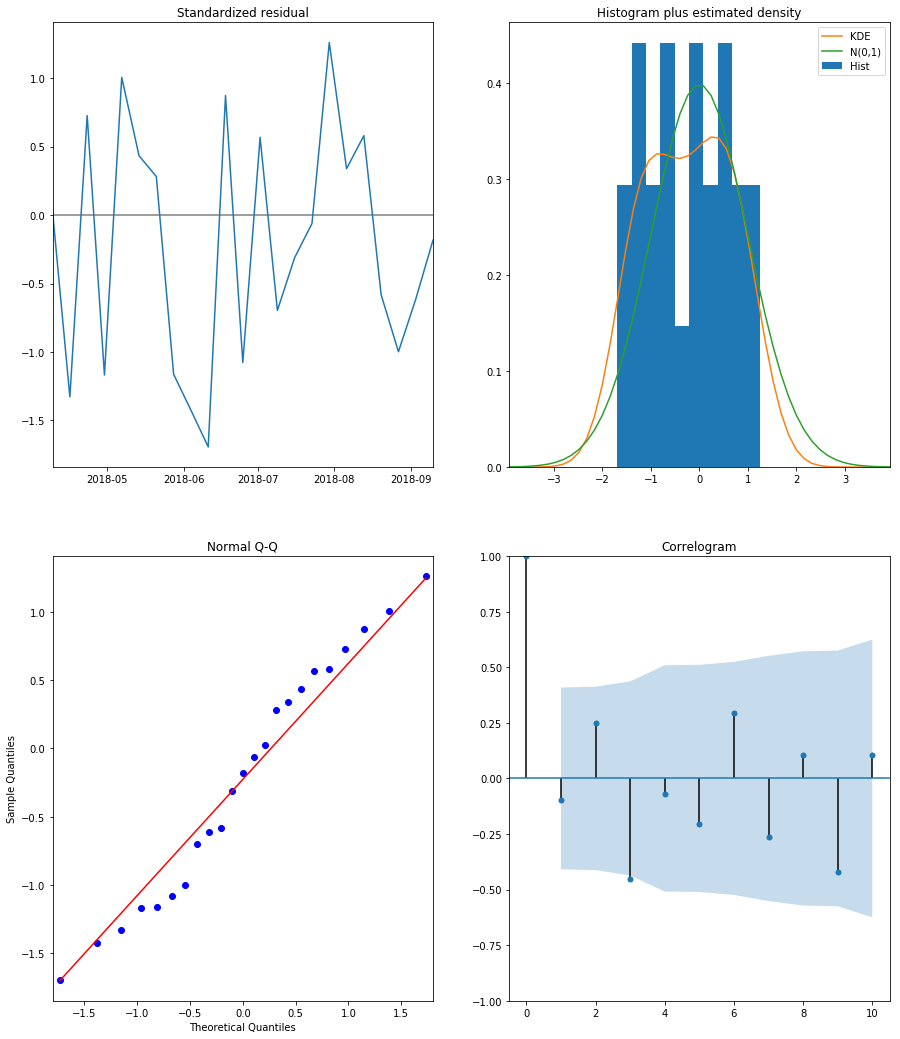

In [42]:
results.plot_diagnostics(figsize=(15, 18))
plt.show()

* KDE line follows closely with the N(0,1) line (where N(0,1)) is the standard notation for a normal distribution with mean 0 and standard deviation of 1). This is a good indication that the residuals are normally distributed.
* The qq-plot on the bottom left shows that the ordered distribution of residuals (blue dots) follows the linear trend of the samples taken from a standard normal distribution with N(0, 1). Again, this is a strong indication that the residuals are normally distributed.
* The residuals over time (top left plot) don't display any obvious seasonality and appear to be white noise. This is confirmed by the autocorrelation (i.e. correlogram) plot on the bottom right, which shows that the time series residuals have low correlation with lagged versions of itself.

## Model Validation

### One-Step Ahead Forecasting
Compare predicted values to real values in the time series

In [63]:
def forecasting(results, dynamic=False):
    # get predictions 
    pred = results.get_prediction(start=pd.to_datetime('2018-01-01'), dynamic=dynamic)
    pred_conf = pred.conf_int()
    # Plot real vs predicted values along with confidence interval
    rcParams['figure.figsize'] = 15, 6

    #Plot observed values
    ax = cdc_df['2017':].plot(label='observed')
    #Plot predicted values
    pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.9)
    #Plot the range for confidence intervals
    ax.fill_between(pred_conf.index,
                    pred_conf.iloc[:, 0],
                    pred_conf.iloc[:, 1], color='g', alpha=.5)
    #Set axes labels
    ax.set_xlabel('Date')
    ax.set_ylabel('ILI-visits')
    plt.legend()
    plt.show()
    # Get the Real and predicted values
    visits_forecasted = pred.predicted_mean
    visits_truth = cdc_df['2018-01-01':]['ILITOTAL']
    # Compute the mean square error
    mse = ((visits_forecasted - visits_truth) ** 2).mean()
    print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

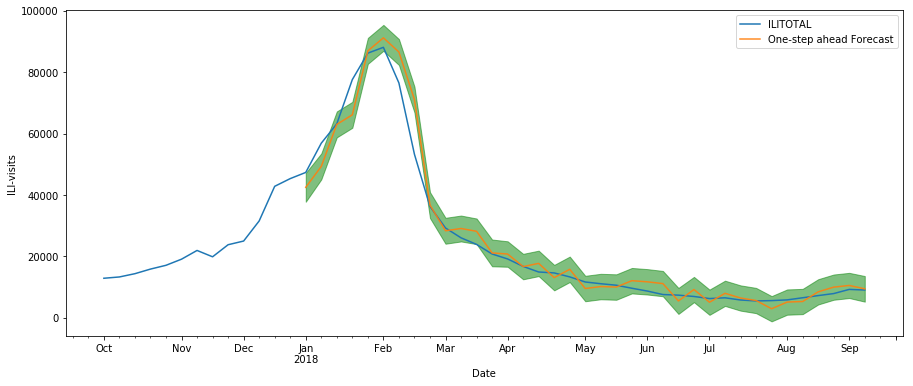

The Mean Squared Error of our forecasts is 20338481.6


In [64]:
forecasting(results, dynamic=False)

### Dynamic Forecasting
Only use information from the time series up to a certain point, and after that, forecasts are generated using values from previous forecasted time points.

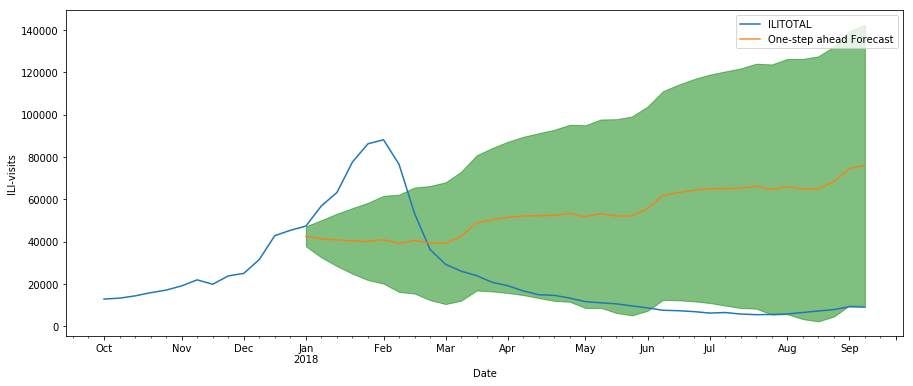

The Mean Squared Error of our forecasts is 2038853072.87


In [65]:
forecasting(results,dynamic=True)

## Producing & Visualizing Forecasts

In [67]:
def get_forecast(steps):
    # Get forecast 500 steps ahead in future
    prediction = results.get_forecast(steps=steps)
    # Get confidence intervals of forecasts
    pred_conf = prediction.conf_int()
    # Plot future predictions with confidence intervals
    ax = cdc_df.plot(label='observed', figsize=(20, 15))
    prediction.predicted_mean.plot(ax=ax, label='Forecast')
    ax.fill_between(pred_conf.index,
                    pred_conf.iloc[:, 0],
                    pred_conf.iloc[:, 1], color='k', alpha=.25)
    ax.set_xlabel('Date')
    ax.set_ylabel('ILI visits')

    plt.legend()
    plt.show()

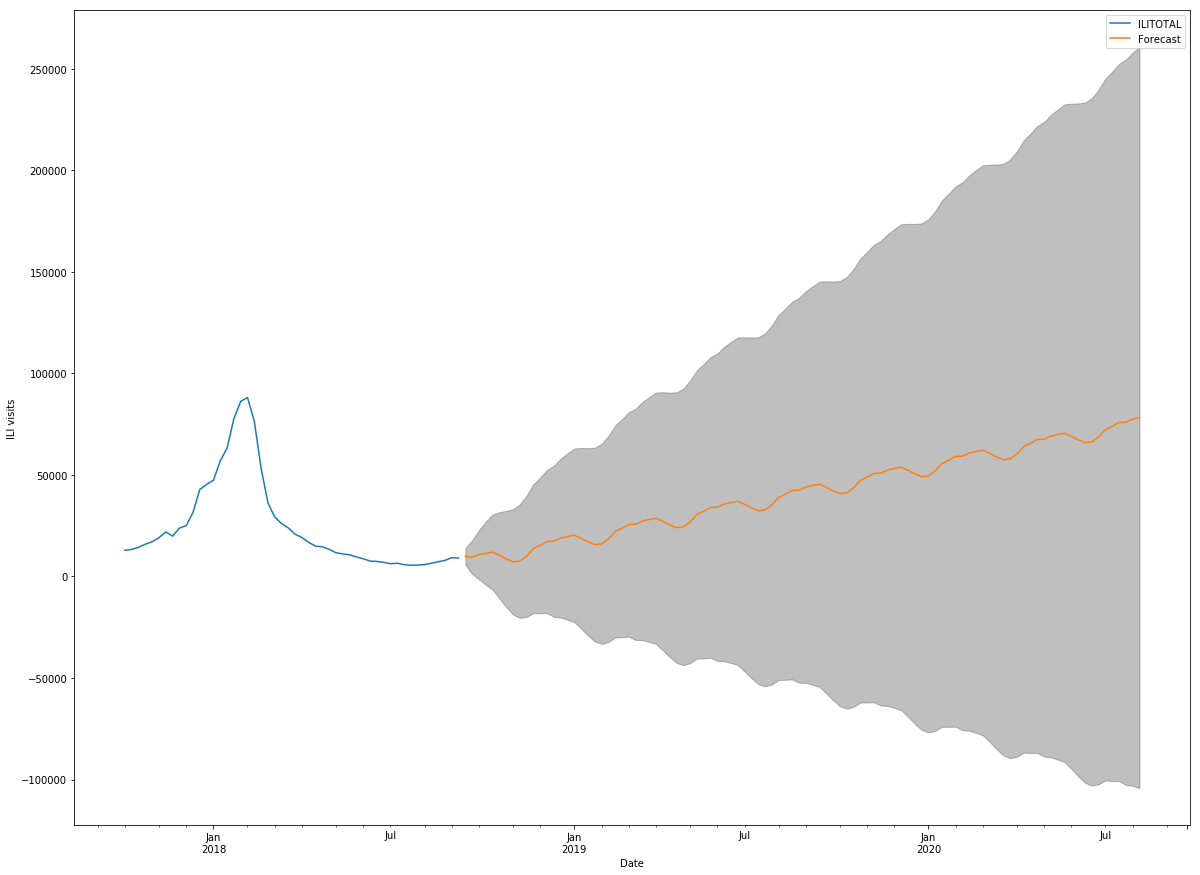

In [69]:
get_forecast(100)

### Model with CDC & Twitter data

### Model with CDC, Twitter, Google Trends data

### Model Selection: Overview of Goodness-of-Fit Measures

### Model Validation: Forecasting

In [9]:
#one-step ahead forecasting for best fitting model - comparing predicted values to real values of the time series, 
#which will help us understand the accuracy of our forecasts (use cross-fold validation)

## Producing & Visualizing Forecasts